In [14]:
import pandas as pd
import matplotlib.pyplot as plt

Data load

In [26]:
bms_soh_df = pd.read_csv('energy_hackathon_data/BESS/ZHPESS232A230002/bms1_soh.csv', parse_dates=['ts'])
bms_soc_df = pd.read_csv('energy_hackathon_data/BESS/ZHPESS232A230002/bms1_soc.csv', parse_dates=['ts'])
bms1_cell_ave_t = pd.read_csv('energy_hackathon_data/BESS/ZHPESS232A230002/bms1_cell_ave_t.csv', parse_dates=['ts'])
bms1_cell_t_diff = pd.read_csv('energy_hackathon_data/BESS/ZHPESS232A230002/bms1_cell_t_diff.csv', parse_dates=['ts'])
pcs1_t_igbt = pd.read_csv('energy_hackathon_data/BESS/ZHPESS232A230002/pcs1_t_igbt.csv', parse_dates=['ts'])
pcs1_t_env = pd.read_csv('energy_hackathon_data/BESS/ZHPESS232A230002/pcs1_t_env.csv', parse_dates=['ts'])
bms1_cell_max_v = pd.read_csv('energy_hackathon_data/BESS/ZHPESS232A230002/bms1_cell_max_v.csv', parse_dates=['ts'])
bms1_cell_min_v = pd.read_csv('energy_hackathon_data/BESS/ZHPESS232A230002/bms1_cell_min_v.csv', parse_dates=['ts'])
bms1_v = pd.read_csv('energy_hackathon_data/BESS/ZHPESS232A230002/bms1_v.csv', parse_dates=['ts'])
bms1_c = pd.read_csv('energy_hackathon_data/BESS/ZHPESS232A230002/bms1_c.csv', parse_dates=['ts'])


In [ ]:
# data exploration
print(bms_soc_df.head())
print(bms_soh_df.head())
print(bms1_cell_ave_t.head())
print(bms1_cell_t_diff.head())
print(pcs1_t_igbt.head())
print(pcs1_t_env.head())
print(bms1_cell_max_v.head())
print(bms1_cell_min_v.head())
print(bms1_v.head())
print(bms1_c.head())


                   ts  bms1_soc
0 2023-09-19 12:09:22        29
1 2023-09-19 12:10:21        29
2 2023-09-19 12:11:20        29
3 2023-09-19 12:12:19        30
4 2023-09-19 12:13:18        30
                   ts  bms1_soh
0 2023-09-19 12:09:22       100
1 2023-09-19 12:10:21       100
2 2023-09-19 12:11:20       100
3 2023-09-19 12:12:19       100
4 2023-09-19 12:13:18       100
                   ts  bms1_cell_ave_t
0 2023-09-19 12:09:22               25
1 2023-09-19 12:10:21               25
2 2023-09-19 12:11:20               25
3 2023-09-19 12:12:19               25
4 2023-09-19 12:13:18               25
                   ts  bms1_cell_t_diff
0 2023-09-19 12:09:22                 0
1 2023-09-19 12:10:21                 0
2 2023-09-19 12:11:20                 0
3 2023-09-19 12:12:19                 0
4 2023-09-19 12:13:18                 0
                   ts  pcs1_t_igbt
0 2024-02-27 00:37:30         12.3
1 2024-02-27 00:39:03         12.3
2 2024-02-27 00:40:03         12.3
3 

In [31]:
def normalize_bess_timestamps(df, timestamp_col='ts', method='floor', aggregation=None):
    """Normalize BESS timestamps to minute-level precision"""
    df_copy = df.copy()
    df_copy[timestamp_col] = pd.to_datetime(df_copy[timestamp_col])
    
    # Floor timestamps to minutes
    df_copy[timestamp_col] = df_copy[timestamp_col].dt.floor('min')
    
    # Default aggregation for numeric columns
    if aggregation is None:
        numeric_cols = df_copy.select_dtypes(include=['number']).columns
        aggregation = {col: 'mean' for col in numeric_cols if col != timestamp_col}
    
    # Aggregate duplicates
    result = df_copy.groupby(timestamp_col).agg(aggregation).round(3).reset_index()
    return result

In [32]:
datasets = {
    'bms_soh': normalize_bess_timestamps(bms_soh_df, aggregation={'bms1_soh': 'mean'}),
    'bms_soc': normalize_bess_timestamps(bms_soc_df, aggregation={'bms1_soc': 'mean'}),
    'cell_ave_t': normalize_bess_timestamps(bms1_cell_ave_t, aggregation={'bms1_cell_ave_t': 'max'}),  # Safety critical
    'cell_t_diff': normalize_bess_timestamps(bms1_cell_t_diff, aggregation={'bms1_cell_t_diff': 'max'}),
    'igbt_temp': normalize_bess_timestamps(pcs1_t_igbt, aggregation={'pcs1_t_igbt': 'max'}),
    'env_temp': normalize_bess_timestamps(pcs1_t_env, aggregation={'pcs1_t_env': 'mean'}),
    'cell_max_v': normalize_bess_timestamps(bms1_cell_max_v, aggregation={'bms1_cell_max_v': 'max'}),
    'cell_min_v': normalize_bess_timestamps(bms1_cell_min_v, aggregation={'bms1_cell_min_v': 'min'}),
    'pack_voltage': normalize_bess_timestamps(bms1_v, aggregation={'bms1_v': 'mean'}),
    'pack_current': normalize_bess_timestamps(bms1_c, aggregation={'bms1_c': 'mean'})
}

# Combine all datasets using merge_asof for time-series alignment
combined_df = datasets['bms_soh']
for name, df in list(datasets.items())[1:]:
    combined_df = pd.merge_asof(
        combined_df.sort_values('ts'),
        df.sort_values('ts'),
        on='ts',
        tolerance=pd.Timedelta('1min'),
        direction='nearest'
    )

In [ ]:
# Derived features for anomaly detection
combined_df['voltage_spread'] = combined_df['bms1_cell_max_v'] - combined_df['bms1_cell_min_v']
combined_df['temp_gradient'] = combined_df['bms1_cell_ave_t'].diff()
combined_df['soc_rate'] = combined_df['bms1_soc'].diff()
combined_df['power'] = combined_df['bms1_v'] * combined_df['bms1_c']

# Save combined dataset
combined_df.to_csv('bess_combined_normalized.csv', index=False)
print(f"Combined dataset saved with shape: {combined_df.shape}")

Combined dataset saved with shape: (884112, 15)


In [34]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884112 entries, 0 to 884111
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ts                884112 non-null  datetime64[ns]
 1   bms1_soh          884112 non-null  float64       
 2   bms1_soc          884112 non-null  float64       
 3   bms1_cell_ave_t   884112 non-null  int64         
 4   bms1_cell_t_diff  884112 non-null  int64         
 5   pcs1_t_igbt       659476 non-null  float64       
 6   pcs1_t_env        884003 non-null  float64       
 7   bms1_cell_max_v   884088 non-null  float64       
 8   bms1_cell_min_v   884088 non-null  float64       
 9   bms1_v            883480 non-null  float64       
 10  bms1_c            883480 non-null  float64       
 11  voltage_spread    884088 non-null  float64       
 12  temp_gradient     884111 non-null  float64       
 13  soc_rate          884111 non-null  float64       
 14  powe

In [17]:
# concat data
soc_soh_df = pd.merge_asof(bms_soc_df.sort_values('ts'), bms_soh_df.sort_values('ts'), on='ts', direction='nearest')

Text(0.5, 1.0, 'BMS SOC and SOH Over Time')

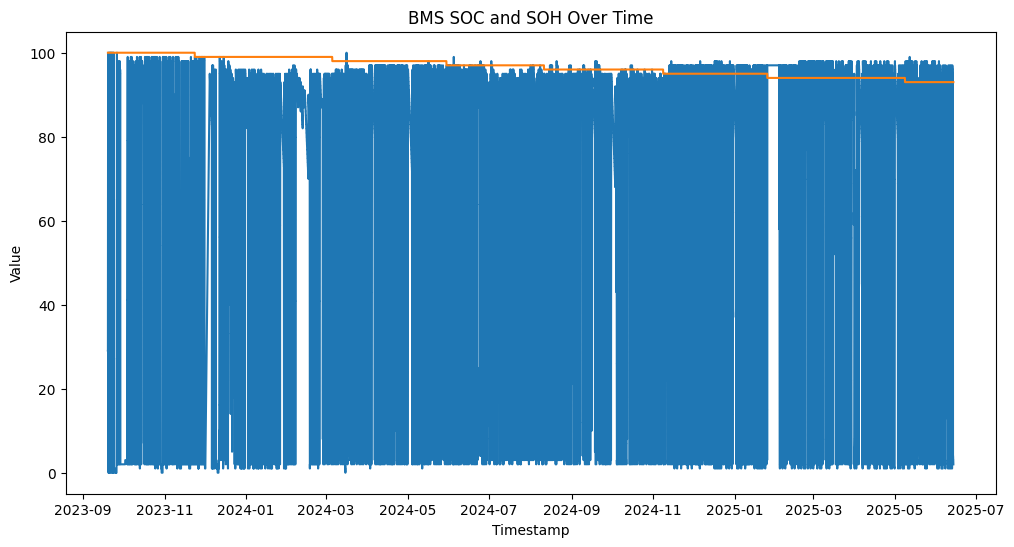

In [35]:
# plot
plt.figure(figsize=(12,6))
plt.plot(soc_soh_df['ts'], soc_soh_df['bms1_soc'], label='SOC')
plt.plot(soc_soh_df['ts'], soc_soh_df['bms1_soh'], label='SOH')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('BMS SOC and SOH Over Time')

<Axes: xlabel='ts'>

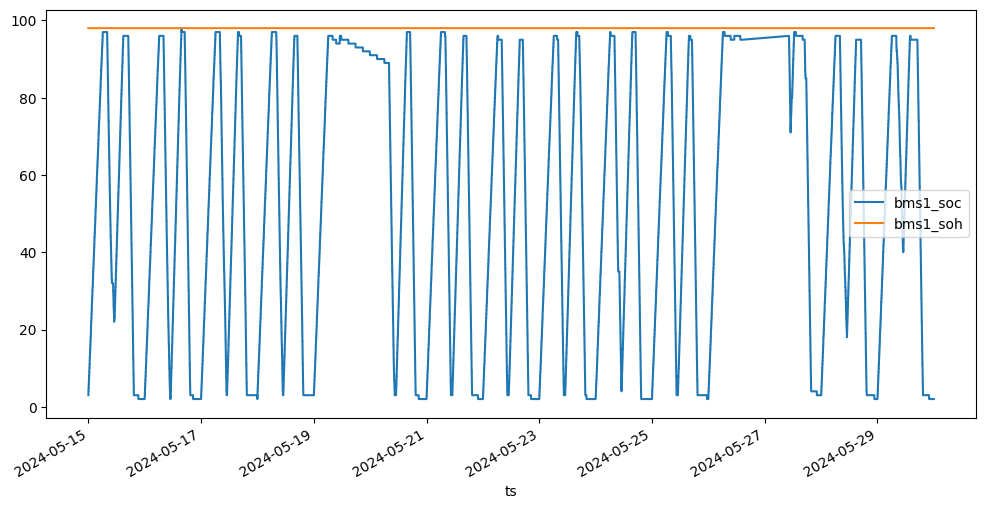

In [36]:
df = soc_soh_df.set_index('ts')

start = "2024-05-15"
end= "2024-05-30"

df[(df.index >= start)&(df.index <= end)].plot(figsize=(12,6))

In [37]:
df.head()

,bms1_soc,bms1_soh
ts,,
2023-09-19 12:09:22,29,100
2023-09-19 12:10:21,29,100
2023-09-19 12:11:20,29,100
2023-09-19 12:12:19,30,100
2023-09-19 12:13:18,30,100


In [42]:
combined_df.head(20)

,ts,bms1_soh,bms1_soc,bms1_cell_ave_t,bms1_cell_t_diff,pcs1_t_igbt,pcs1_t_env,bms1_cell_max_v,bms1_cell_min_v,bms1_v,bms1_c,voltage_spread,temp_gradient,soc_rate,power
0,2023-09-19 12:09:00,100.0,29.0,25,0,NaN,50.1,3.4,3.3,NaN,NaN,0.1,NaN,NaN,NaN
1,2023-09-19 12:10:00,100.0,29.0,25,0,NaN,50.1,3.4,3.3,NaN,NaN,0.1,0.0,0.0,NaN
2,2023-09-19 12:11:00,100.0,29.0,25,0,NaN,50.2,3.4,3.3,NaN,NaN,0.1,0.0,0.0,NaN
3,2023-09-19 12:12:00,100.0,30.0,25,0,NaN,50.2,3.4,3.3,NaN,NaN,0.1,0.0,1.0,NaN
4,2023-09-19 12:13:00,100.0,30.0,25,0,NaN,50.4,3.4,3.3,NaN,NaN,0.1,0.0,0.0,NaN
5,2023-09-19 12:14:00,100.0,31.0,25,0,NaN,50.4,3.4,3.3,NaN,NaN,0.1,0.0,1.0,NaN
6,2023-09-19 12:15:00,100.0,31.0,25,0,NaN,50.4,3.4,3.3,NaN,NaN,0.1,0.0,0.0,NaN
7,2023-09-19 12:16:00,100.0,31.0,25,0,NaN,50.4,3.4,3.3,NaN,NaN,0.1,0.0,0.0,NaN
8,2023-09-19 12:17:00,100.0,32.0,25,0,NaN,50.3,3.4,3.3,NaN,NaN,0.1,0.0,1.0,NaN
9,2023-09-19 12:18:00,100.0,32.0,25,0,NaN,50.2,3.4,3.3,NaN,NaN,0.1,0.0,0.0,NaN
